# The Full Pipeline

**Inputs**: 
- config file
- image files
- well mask file

**Outputs**:
- droplets DataFrame (csv) 
- wells DataFrame (csv)
- condensed DataFrame (csv)
- jupyter notebook pre-loaded with basic quality control plots

We have built all the necessary parts in other python notebooks and moved code to kchip_v0 package. Now, implement each step. 

#### Step 1: Create droplets DataFrame
The droplets dataFrame contains information of all droplets in the pre-merge image set. We need to compute and store:
- the RGB information of each droplet
- the cluster and cluster label of each droplet
- the location of each droplet
- the well ID of each droplet

All of these steps can be found in the "Putting it together" notebook. 

#### Step 2: Create wells DataFrame
- Loop through post-merge images and identify wells
- Map post-merge wells to pre-merge wells
- Condense outputs to final dataframe

All of these steps can be found in the "Registration" notebook and Final Outputs. 


### Step 0: Imports and config

In [6]:
# basic imports 
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Append top level directory with kchip package
import sys
sys.path.append('/Users/mandy/Develop/PyCharm/BPCP/')

# kchip imports
import kchip.io as kchip_io
import kchip.analyze as kchip_analyze

# Other
%matplotlib inline

# Read in config file
with open('/Users/mandy/Develop/PyCharm/BPCP/kchip/Accessory/config/config24.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile)
    
print (yaml.dump(config))

barcodes:
  cluster:
    eps: 0.01
    min_samples: 10
    offset:
    - 600
    - 600
    - 600
    points_to_cluster: 2000
  path: ../Chip24_data/Notes.xlsx
image:
  base_path: ../Chip24_data/
  bugs: 0
  dyes:
  - 1
  - 3
  - 2
  names:
    premerge: Chip24_premerge
    t0: Chip24_t0
    t1: Chip24_t1
    t2: Chip24_t2
  overlap: 0.05
  pixel_size: 6.5
  size: 1024
  well_start_image:
  - 1
  - 1
  well_start_xy:
  - 518
  - 434
well_mask:
  filename: ../Well Masks/k2_mask.tif
  pixel_size: 8.33625
  well_start_xy:
  - 242
  - 378



/Library/Python/3.7/site-packages/ipykernel_launcher.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [2]:
fontsize = 14
plt.rcParams['axes.spines.right']=False
plt.rcParams['axes.spines.top']=False

plt.rcParams['axes.linewidth']=3
plt.rcParams['axes.labelsize']=fontsize
plt.rcParams['lines.linewidth']=2
plt.rcParams['xtick.labelsize']=fontsize
plt.rcParams['ytick.labelsize']=fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size']=fontsize
plt.rcParams['xtick.major.width']=1.5
plt.rcParams['ytick.major.width']=1.5
plt.rcParams['contour.negative_linestyle'] = 'solid'

plt.rcParams['savefig.bbox']='Tight'
plt.rcParams['pdf.fonttype'] = 42

### Step 1: Create droplets DataFrame
- Initialize from images
- Identify droplets in the same well from fit to masks
- Cluster
- Map apriori labels to clusters

Creating droplets from: 8,1


/Users/mandy/Develop/PyCharm/BPCP/kchip/matchmask.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return image[slices]


Creating droplets from: 8,3
Creating droplets from: 8,2
Creating droplets from: 8,6
Creating droplets from: 8,7
Creating droplets from: 8,5
Creating droplets from: 8,4
Creating droplets from: 9,3
Creating droplets from: 9,2
Creating droplets from: 9,1
Creating droplets from: 9,5
Creating droplets from: 9,4
Creating droplets from: 9,6
Creating droplets from: 9,7
Creating droplets from: 3,1
Creating droplets from: 1,3
Creating droplets from: 7,5
Creating droplets from: 5,7
Creating droplets from: 5,6
Creating droplets from: 7,4
Creating droplets from: 10,1
Creating droplets from: 1,2
Creating droplets from: 3,2
Creating droplets from: 10,3
Creating droplets from: 7,6
Creating droplets from: 5,4
Creating droplets from: 5,5
Creating droplets from: 7,7
Creating droplets from: 10,2
Creating droplets from: 1,1
Creating droplets from: 3,3
Creating droplets from: 3,7
Creating droplets from: 1,5
Creating droplets from: 10,6
Creating droplets from: 7,3
Creating droplets from: 5,1
Creating droplet

/Users/mandy/Develop/PyCharm/BPCP/kchip/analyze.py:172: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask = well_mask[mask_xy(x,y,100)]


Shift:  [213.  26.]
Fitting droplets to well mask in: 8 3
Shift:  [102. -74.]
Fitting droplets to well mask in: 8 2
Shift:  [-91. -29.]
Fitting droplets to well mask in: 8 6
Shift:  [  30. -103.]
Fitting droplets to well mask in: 8 7
Shift:  [93. 85.]
Fitting droplets to well mask in: 8 5
Shift:  [-116.  107.]
Fitting droplets to well mask in: 8 4
Shift:  [  28. -104.]
Fitting droplets to well mask in: 9 3
Shift:  [-81.  91.]
Fitting droplets to well mask in: 9 2
Shift:  [-45.  44.]
Fitting droplets to well mask in: 9 1
Shift:  [222.  37.]
Fitting droplets to well mask in: 9 5
Shift:  [92. -1.]
Fitting droplets to well mask in: 9 4
Shift:  [36. 29.]
Fitting droplets to well mask in: 9 6
Shift:  [80. 90.]
Fitting droplets to well mask in: 9 7
Shift:  [99. 90.]
Fitting droplets to well mask in: 3 1
Shift:  [-17.  27.]
Fitting droplets to well mask in: 1 3
Shift:  [  13. -150.]
Fitting droplets to well mask in: 7 5
Shift:  [99. 94.]
Fitting droplets to well mask in: 5 7
Shift:  [107.  10.

/Users/mandy/Library/Python/3.7/lib/python/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/Users/mandy/Library/Python/3.7/lib/python/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Total droplets identified:  68537


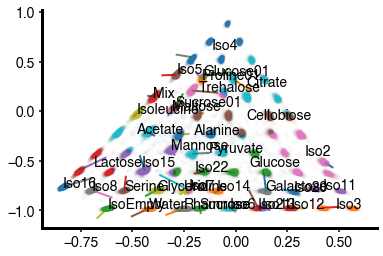

In [3]:
# Initialize droplets DataFrame from images
droplets, rotation_theta = kchip_analyze.initialize_droplets(config)

print ('Rotation (degrees): ', rotation_theta*180/np.pi)

# Identify droplets in the same well from fit to masks
droplets = kchip_analyze.fit_droplets_to_mask(config,droplets,rotation_theta)

# Cluster droplets and map apriori labels to clusters
droplets, centroids = kchip_analyze.identify_clusters(config,droplets,show=1)

print ('Total droplets identified: ', droplets.shape[0])

### Step 2: Create wells DataFrame
- Create pre-merge wells dataFrame
- Loop through post-merge images and identify wells
- Map post-merge wells to pre-merge wells

In [4]:
# Identify premerge wells
pre_wells = droplets.groupby(['IndexX','IndexY','Well_ID'],as_index=False)[['ImageX','ImageY','Edge']].mean()

# List of timepoints
timepoints = ['t'+str(i) for i in range(3)]

# Analyze data for each timepoint
pre_post_all = []
for timepoint in timepoints:
    print ('Now analyzing timepoint: ', timepoint)
    # Identify postmerge wells and map to pre-merge wells
    pre_post_all.append(kchip_analyze.map_pre_to_post(config,timepoint,pre_wells))
    pre_post_all[-1].to_csv(timepoint+'.csv')

# Condense output
condensed = kchip_analyze.stack_timepoints(droplets,pre_post_all,timepoints)

Now analyzing timepoint:  t0
Now analyzing: 6,4
Now analyzing: 4,6
Now analyzing: 4,7
Now analyzing: 6,5
Now analyzing: 2,1
Now analyzing: 2,3
Now analyzing: 6,7
Now analyzing: 4,5
Now analyzing: 4,4
Now analyzing: 6,6
Now analyzing: 2,2
Now analyzing: 2,6
Now analyzing: 6,2
Now analyzing: 4,1
Now analyzing: 6,3
Now analyzing: 2,7
Now analyzing: 2,5
Now analyzing: 6,1
Now analyzing: 4,3
Now analyzing: 4,2
Now analyzing: 2,4
Now analyzing: 5,5
Now analyzing: 7,7
Now analyzing: 1,1
Now analyzing: 3,3
Now analyzing: 10,1
Now analyzing: 3,2
Now analyzing: 7,6
Now analyzing: 5,4
Now analyzing: 5,6
Now analyzing: 7,4
Now analyzing: 1,2
Now analyzing: 10,3
Now analyzing: 10,2
Now analyzing: 3,1
Now analyzing: 1,3
Now analyzing: 7,5
Now analyzing: 5,7
Now analyzing: 5,3
Now analyzing: 7,1
Now analyzing: 1,7
Now analyzing: 3,5
Now analyzing: 10,6
Now analyzing: 10,7
Now analyzing: 3,4
Now analyzing: 1,6
Now analyzing: 5,2
Now analyzing: 7,2
Now analyzing: 1,4
Now analyzing: 3,6
Now analyzing: 1

In [5]:
# Save outputs
droplets.to_csv('droplets.csv')
condensed.to_csv('output.csv')

## Quality control outputs

### Chip loading and global well positions

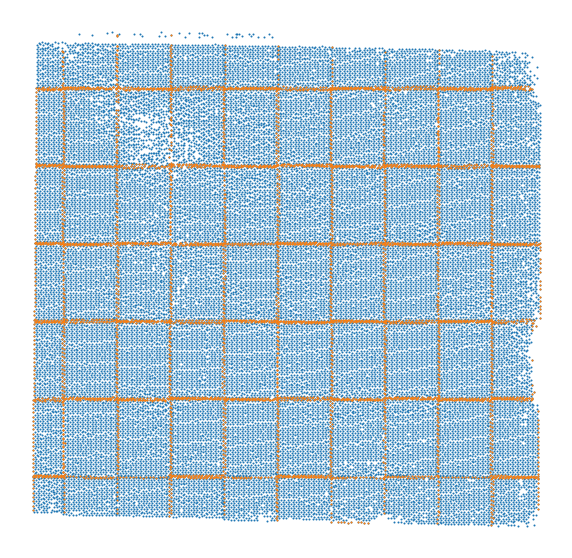

In [6]:
well_positions = pre_post_all[-1].groupby('Hash').mean()[['Pre_GlobalX','Pre_GlobalY']].values
edge = pre_post_all[-1].groupby('Hash').mean()['Pre_Edge'].values

fig, axes = plt.subplots(figsize=(10,10))

axes.plot(well_positions[:,0],-well_positions[:,1],'.',ms=2)
axes.plot(well_positions[edge,0],-well_positions[edge,1],'.',ms=2)
plt.axis('off');

### Plot by total droplets in well

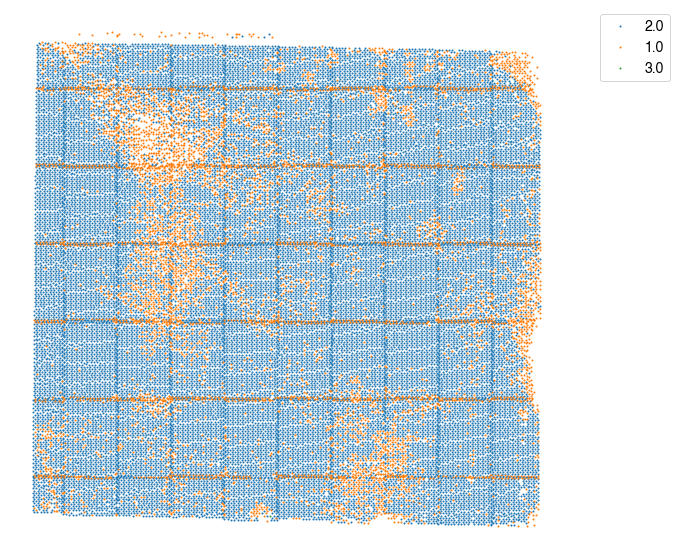

In [7]:
def plot_by_count(df,ax):
    for item in df['Total'].unique():
        pos = df[(df['Total']==item)][['Pre_GlobalX','Pre_GlobalY']].values
        ax.plot(pos[:,0],-pos[:,1],'.',ms=2)
    return ax

fig, axes = plt.subplots(figsize=(10,10))
        
condensed[['Hash','Total','t2_Area']] \
    .merge(pre_post_all[-1][['Hash','Pre_GlobalX','Pre_GlobalY','Pre_Edge']],on='Hash') \
    .pipe(plot_by_count,ax=axes) 
    
axes.legend(condensed['Total'].unique(),loc=2,bbox_to_anchor=(1.05,1))
plt.axis('off');

### Plot area over chip

Text(0, 0.5, 'Count')

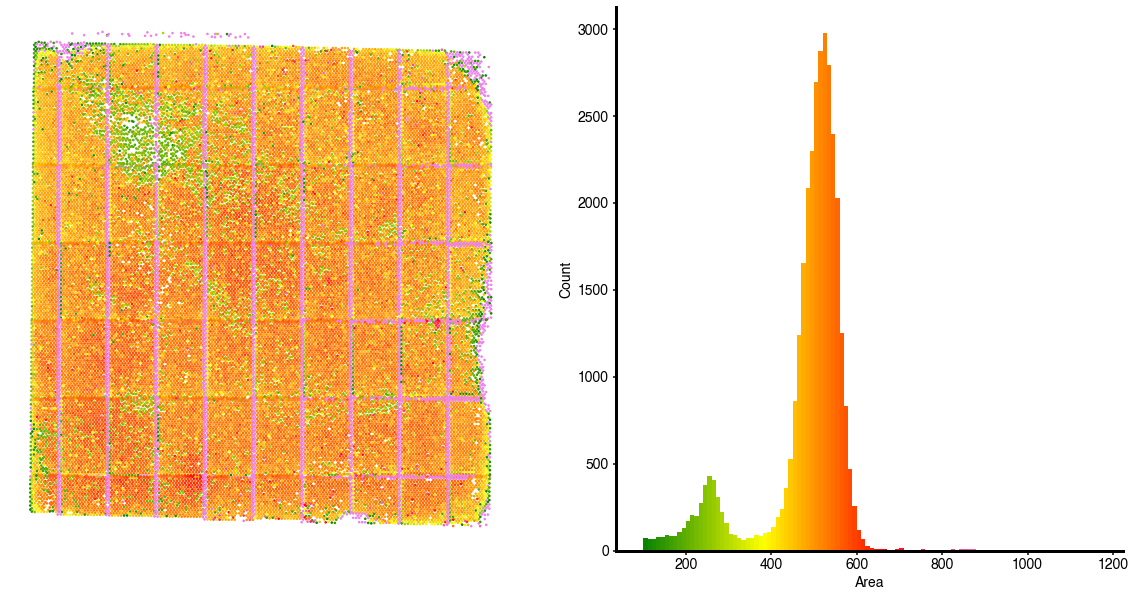

In [9]:
from matplotlib import colors

data = condensed[['Hash','Total','t2_Area']] \
    .merge(pre_post_all[-1][['Hash','Pre_GlobalX','Pre_GlobalY','Pre_Edge']],on='Hash') 

width = 1e1
bins = np.arange(0,2e3,width)

bin_by_area = pd.cut(data['t2_Area'],bins)
bin_label = dict([(item,i) for i, item in enumerate(bin_by_area.unique().sort_values())])

data['Area_Bin']=[bin_label[item] for item in bin_by_area]

cmap = colors.LinearSegmentedColormap.from_list('', ['green','yellow','red','violet'],N=data['Area_Bin'].max())

fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(data['Pre_GlobalX'],-data['Pre_GlobalY'],c=data['Area_Bin'],cmap=cmap,marker='.',s=10,alpha=1)
axes[0].axis('off')

invert_label = {v: k for k, v in bin_label.items()}

for label in invert_label.keys():
    if invert_label[label]==invert_label[label]:
        axes[1].bar(invert_label[label].mid,(data['Area_Bin']==label).sum(),width=width,color=cmap(label))

axes[1].set_xlabel('Area')
axes[1].set_ylabel('Count')

### Representation

Text(0.5, 1.0, 'Representation')

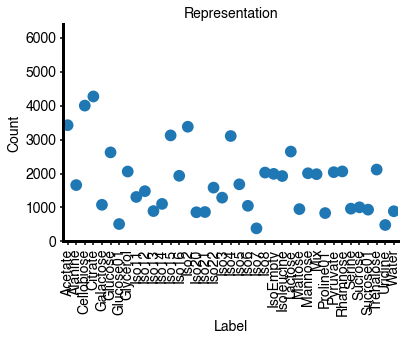

In [11]:
import seaborn as sns

fig, ax = plt.subplots()

p = sns.pointplot(data=droplets.groupby('Label').count().reset_index(),x='Label',y='RX',join=False)

p.set_xticklabels(p.get_xticklabels(),rotation=90)
p.set_ylim([0,droplets.groupby('Label').count()['RX'].max()*1.5]);
p.set_ylabel('Count')
p.set_title('Representation')

### Histograms of GFP and Area values

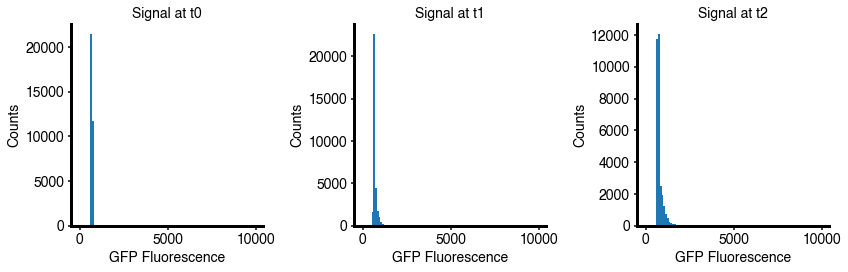

In [12]:
timepoints = condensed.filter(regex='t\d+(?!_)').columns.values

fig, axes = plt.subplots(1,len(timepoints),figsize=(4*len(timepoints),4))

bins = np.arange(0,1e4,1e2)

for ax, t in zip(axes,timepoints):
    ax.hist(condensed[t].dropna(),bins=bins)
    ax.set_xlabel('GFP Fluorescence')
    ax.set_ylabel('Counts')
    ax.set_title('Signal at '+t)

plt.tight_layout()

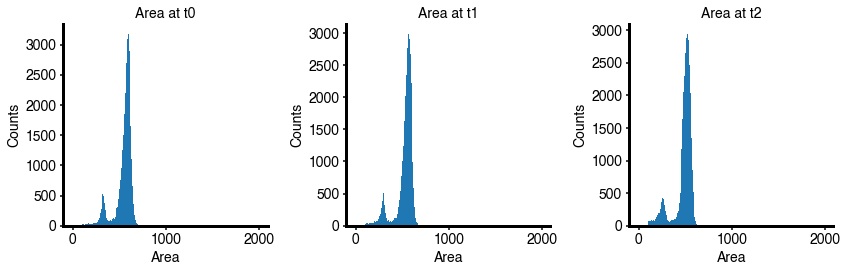

In [13]:
timepoints = condensed.filter(regex='t\d+_Area').columns.values

fig, axes = plt.subplots(1,len(timepoints),figsize=(4*len(timepoints),4))

bins = np.arange(0,2e3,1e1)

for ax, t in zip(axes,timepoints):
    ax.hist(condensed[t].dropna(),bins=bins)
    ax.set_xlabel('Area')
    ax.set_ylabel('Counts')
    ax.set_title('Area at '+t[:-5])

plt.tight_layout()